In [1]:
import pandas as pd
import numpy as np
import sklearn
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

import datetime
print(datetime.datetime.now())

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

2021-01-22 00:31:24.145128


# Load Data

- Exploratory 

In [2]:
test = pd.read_csv('testSamples.csv')
trans = pd.read_csv('TransData.csv')

In [3]:
trans.head(5)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
    trans.describe().T
    
trans['transaction_id'].unique()
trans['sample_id'].unique()
trans['transaction_amount'].unique()


,transaction_id,sample_id,transaction_type,transaction_amount
0,52346326,11,REBILL,24.95
1,52346327,11,REBILL,24.95
2,52346328,32,REBILL,29.95
3,52346329,32,REBILL,29.95
4,52346330,32,REBILL,29.95


,count,mean,std,min,25%,50%,75%,max
transaction_id,7430.0,52350040.5,2145.0,52346326.0,52348183.2,52350040.5,52351897.8,52353755.0
sample_id,7430.0,30245.9,17064.7,11.0,15866.2,30557.0,44945.0,59694.0
transaction_amount,7430.0,24.9,15.1,-40.0,24.9,24.9,33.0,40.0


array([52346326, 52346327, 52346328, ..., 52353753, 52353754, 52353755],
      dtype=int64)

array([   11,    32,   103, ..., 59654, 59689, 59694], dtype=int64)

array([ 24.95,  29.95,  19.95,  32.95,  39.95, -29.95, -24.95, -32.95,
       -19.95, -39.95])

In [4]:
test.head(5)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
    test.describe().T

,sample_id,test_group
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


,count,mean,std,min,25%,50%,75%,max
sample_id,59721.0,29861.0,17240.1,1.0,14931.0,29861.0,44791.0,59721.0
test_group,59721.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0


# Basic Wrangling and Cleaning

- Merge test and trans
- Group by different Price



In [5]:
trans_1 = trans.merge(test, how="left", on="sample_id")

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
    trans_1.describe().T
    
trans_1['transaction_id'].unique()
trans_1['sample_id'].unique()
trans_1['transaction_amount'].unique()
trans_1['test_group'].unique()

,count,mean,std,min,25%,50%,75%,max
transaction_id,7430.0,52350040.5,2145.0,52346326.0,52348183.2,52350040.5,52351897.8,52353755.0
sample_id,7430.0,30245.9,17064.7,11.0,15866.2,30557.0,44945.0,59694.0
transaction_amount,7430.0,24.9,15.1,-40.0,24.9,24.9,33.0,40.0
test_group,7430.0,0.5,0.5,0.0,0.0,0.0,1.0,1.0


array([52346326, 52346327, 52346328, ..., 52353753, 52353754, 52353755],
      dtype=int64)

array([   11,    32,   103, ..., 59654, 59689, 59694], dtype=int64)

array([ 24.95,  29.95,  19.95,  32.95,  39.95, -29.95, -24.95, -32.95,
       -19.95, -39.95])

array([1, 0], dtype=int64)

In [6]:
mapping = pd.DataFrame({'amount':[19.95,24.95,29.95,32.95,39.95],
                      'category':["price_1","price_2","price_3","price_4","price_5"]})
mapping.dtypes

amount      float64
category     object
dtype: object

In [7]:
trans_1['amount'] = abs(trans_1['transaction_amount'])

trans_2 = trans_1.merge(mapping, how="left", on='amount')

trans_2.head(5)
trans_2.groupby(['category']).mean()

,transaction_id,sample_id,transaction_type,transaction_amount,test_group,amount,category
0,52346326,11,REBILL,24.95,1,24.95,price_2
1,52346327,11,REBILL,24.95,1,24.95,price_2
2,52346328,32,REBILL,29.95,1,29.95,price_3
3,52346329,32,REBILL,29.95,1,29.95,price_3
4,52346330,32,REBILL,29.95,1,29.95,price_3


,transaction_id,sample_id,transaction_amount,test_group,amount
category,,,,,
price_1,5.234983e+07,28609.859568,16.655787,0.00000,19.95
price_2,5.235007e+07,30522.910566,21.974830,0.44717,24.95
price_3,5.235023e+07,31710.126027,26.448995,1.00000,29.95
price_4,5.234997e+07,29684.765710,28.348759,0.00000,32.95
price_5,5.235010e+07,30705.910909,36.318182,1.00000,39.95


#  Group analysis

- Assumption: different transaction amount means different products
- A/B Test is applied to Category Price 2, where transaction amount is 24.95
- Focues on Category : 24.95
- Identify cancelled client 
- Identify Outlier - total transaction amount < 0 

In [8]:
p2 = trans_2[trans_2['category']=='price_2']
p2

,transaction_id,sample_id,transaction_type,transaction_amount,test_group,amount,category
0,52346326,11,REBILL,24.95,1,24.95,price_2
1,52346327,11,REBILL,24.95,1,24.95,price_2
25,52346351,138,REBILL,24.95,1,24.95,price_2
44,52346370,494,REBILL,24.95,0,24.95,price_2
45,52346371,494,REBILL,24.95,0,24.95,price_2
...,...,...,...,...,...,...,...
7421,52353747,59581,REBILL,24.95,1,24.95,price_2
7424,52353750,59631,REFUND,-24.95,1,24.95,price_2
7427,52353753,59689,REBILL,24.95,0,24.95,price_2
7428,52353754,59689,REBILL,24.95,0,24.95,price_2


In [9]:
outlier_v1 = p2.groupby(['sample_id']).min()
outlier_v1['cancel'] = outlier_v1['transaction_amount']<0

outlier_v1 = outlier_v1.drop(['transaction_id','transaction_type','transaction_amount','test_group','category','amount'],axis = 1)

outlier_v2 = p2.groupby(['sample_id']).sum()
outlier_v2['outlier'] = outlier_v2['transaction_amount']<0

outlier_v2= outlier_v2.drop(['transaction_id','transaction_amount','test_group','amount'],axis = 1)



In [10]:
p2_v1 = p2.merge(outlier_v1, how="left", on='sample_id')
p2_v2 = p2_v1.merge(outlier_v2, how="left", on='sample_id')


,transaction_id,sample_id,transaction_type,transaction_amount,test_group,amount,category,cancel,outlier
0,52346326,11,REBILL,24.95,1,24.95,price_2,False,False
1,52346327,11,REBILL,24.95,1,24.95,price_2,False,False
2,52346351,138,REBILL,24.95,1,24.95,price_2,False,False
3,52346370,494,REBILL,24.95,0,24.95,price_2,False,False
4,52346371,494,REBILL,24.95,0,24.95,price_2,False,False


c:\users\alex\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='transaction_amount', ylabel='Density'>

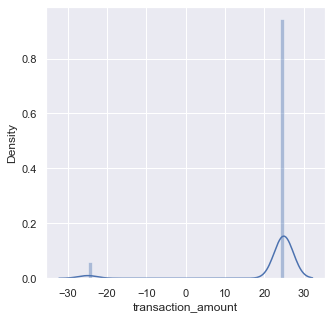

In [11]:
p2_v2.head(5)
sns.distplot(p2_v2['transaction_amount'])

# Questions

1. What is the aproximate probability distribution between the test group and the control group
2. Is a user that must call-in to cancel more likely to generate at least 1 addition REBILL?
3. Is a user that must call-in to cancel more likely to generate more revenues?
4. Is a user that must call-in more likely to produce a higher chargeback rate(CHARGEBACKs/REBILLs)?

,transaction_id,transaction_amount,test_group,amount,cancel,outlier
sample_id,,,,,,
494,157039113,74.85,0,74.85,0,0
957,104692823,-49.90,0,49.90,2,2
1440,52346459,24.95,0,24.95,0,0
1488,209385862,99.80,0,99.80,0,0
1505,104692937,49.90,0,49.90,0,0
...,...,...,...,...,...,...
59092,104707367,49.90,0,49.90,0,0
59106,104707371,-49.90,0,49.90,2,2
59570,104707483,49.90,0,49.90,0,0


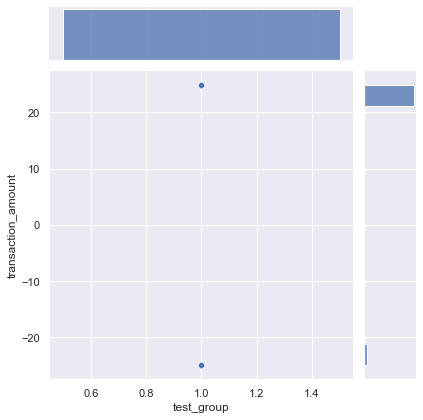

In [12]:
p2_v3 = p2_v2[p2_v2['test_group']==0]
p2 = trans_2[trans_2['category']=='price_2']
p2_v3.groupby(['sample_id']).sum()
test = p2_v2['test_group']=1
sns.jointplot(x='test_group', y='transaction_amount',data=p2_v2)

## DUE TO TIME LIMITATION, TO BE COMPLETED ------ 

### Short Answer
By calculate average rebill count by client, average rebill is higher in control group, it seems that changing from web form to phone call doesn't help improve revenue. Retained rate (1 - cancellation rate) of user is higher in control group as well. 
Also, control group has a higher CHARGEBBACKs rate than test group. 

More to investigate:
- Around 60 people only have negative transaction amount, no positive payment
- test group performance is worse than control group, need more investigation
- more calculation is required to compare A/B at different price level 